In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


## Data viusalization

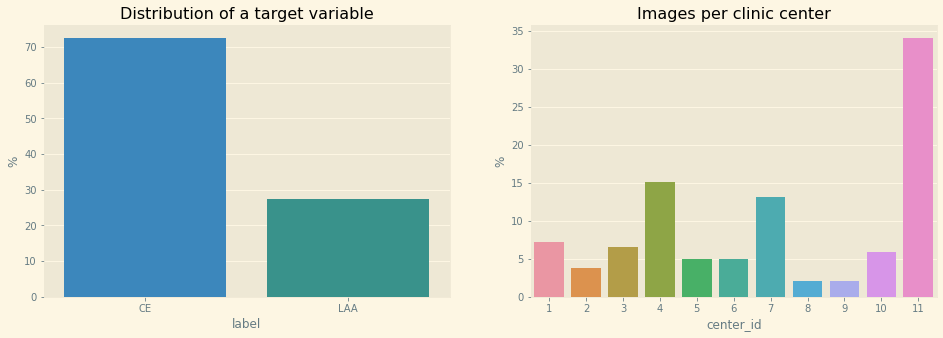

Train Size = 754
Test Size = 4


In [3]:
##### CLASS DISTRIBUTION

plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [5]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


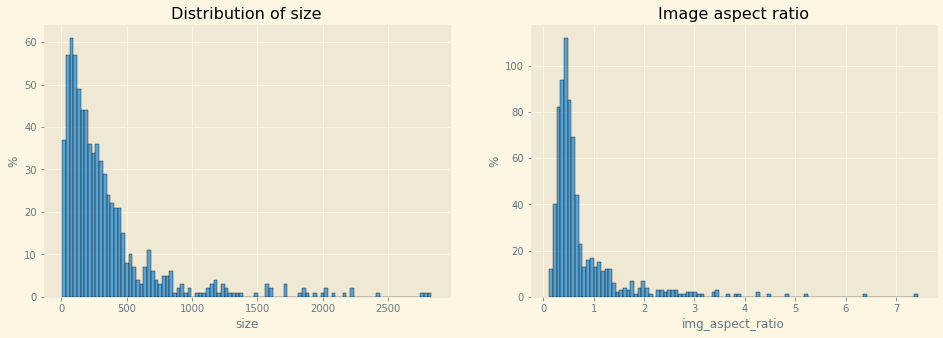

In [6]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

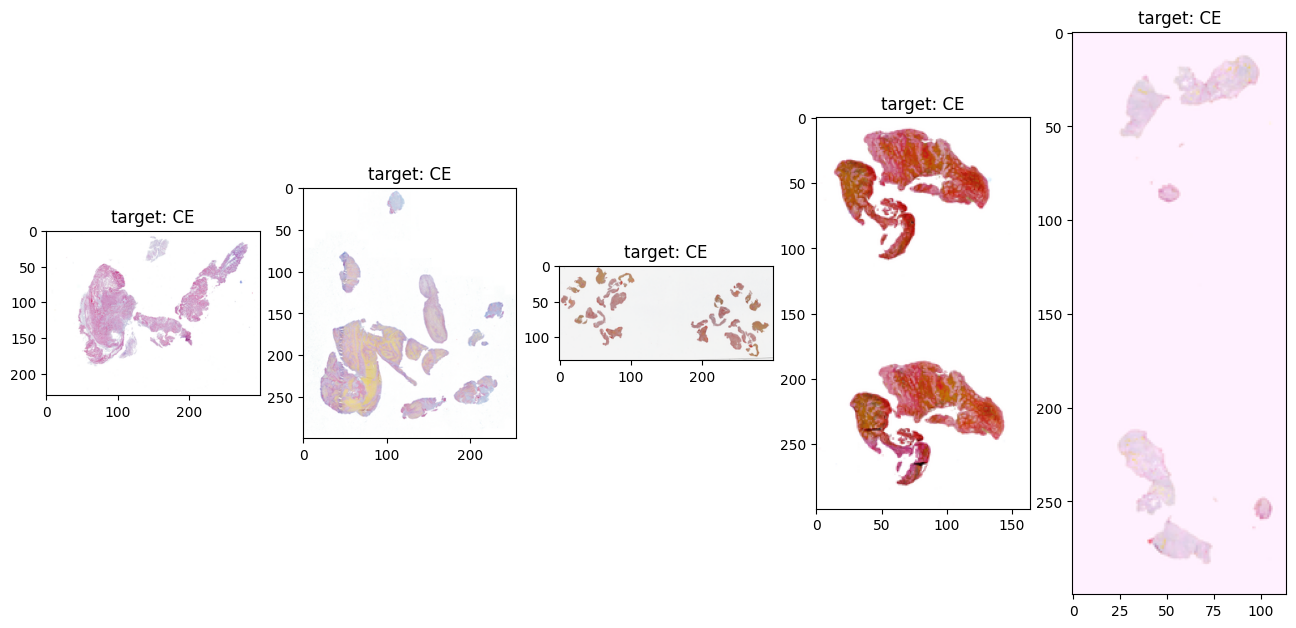

In [7]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

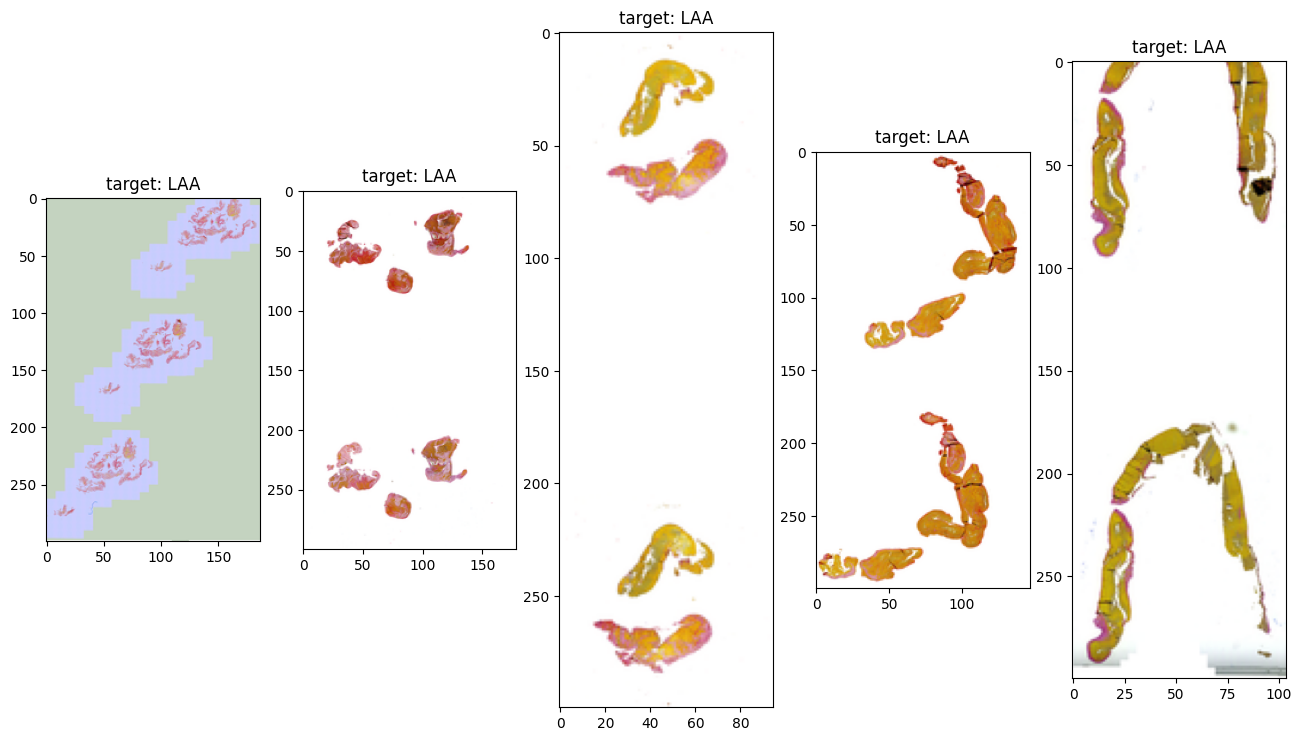

In [8]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

## First impressions:

- Images sizes are from small ones to a high-resolution ones
- Images have different aspect ratios
- Backgrounds have different colours
- Clots are usually in the form of multiple small pieces
- Blood clots have different colours

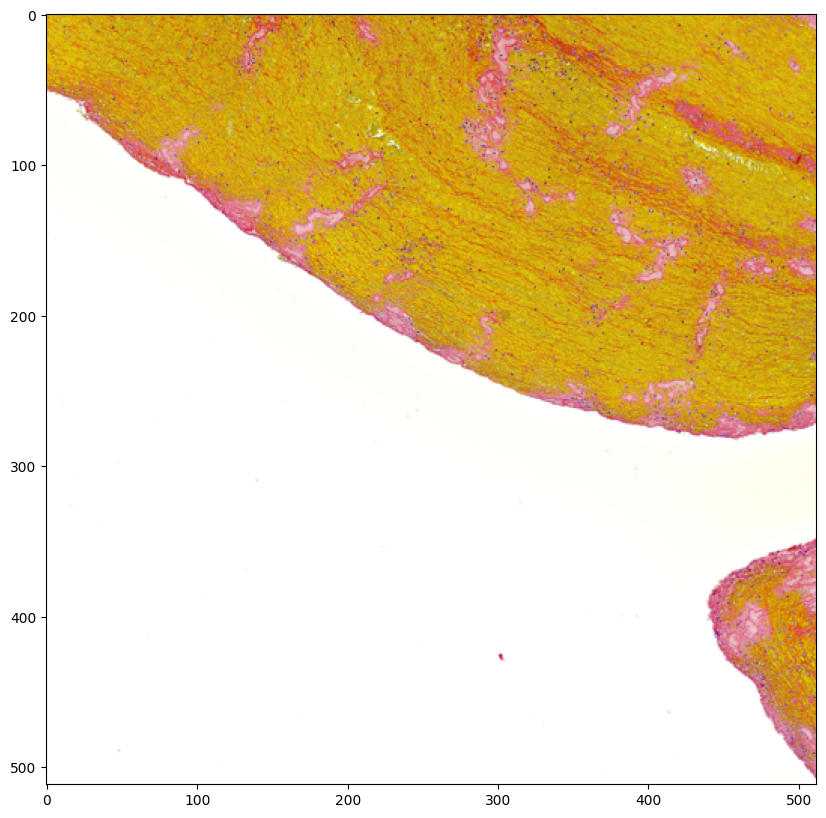

In [9]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


![image](https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg)

## Approach 1

## Loading Data

In [10]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [11]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## Preprocessing

In [12]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 754/754 [42:05<00:00,  3.35s/it]

CPU times: user 15min 36s, sys: 3min 16s, total: 18min 53s
Wall time: 42min 5s


In [13]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [14]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [15]:
print(x_train.shape)

(603, 128, 128, 4)


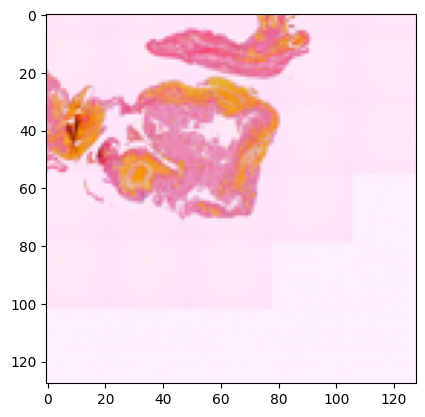

In [16]:
plt.imshow(x_train[0])

## Our CNN approach

In [17]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
from keras import metrics

model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))

model.add(Dropout(0.13))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.13))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1 , activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

2023-01-05 16:58:43.244416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:58:43.384445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:58:43.385490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:58:43.395745: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

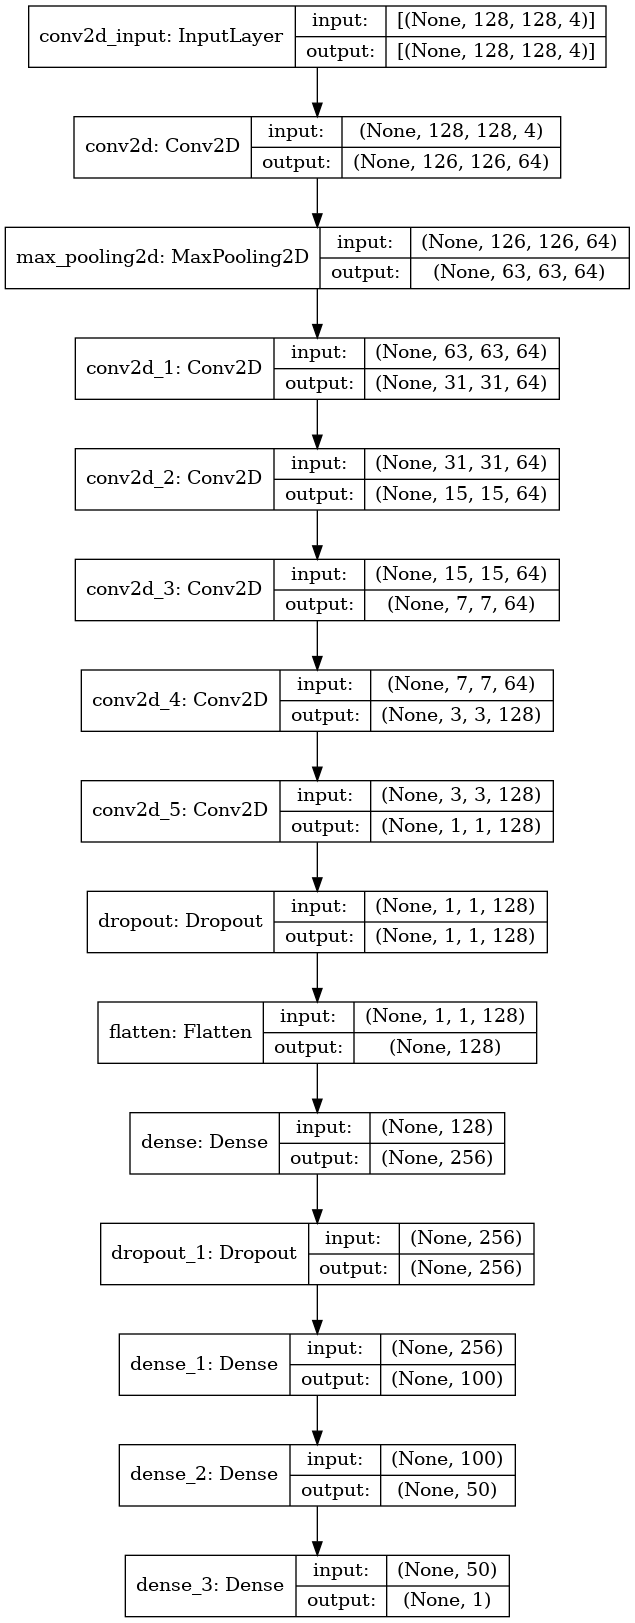

In [19]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## This is where we balance class weights

In [20]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

## Training the model

In [21]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='our_cnn_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [22]:
model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback
)

2023-01-05 16:58:48.316301: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 158072832 exceeds 10% of free system memory.
2023-01-05 16:58:48.677230: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 158072832 exceeds 10% of free system memory.
2023-01-05 16:58:48.855793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-05 16:58:50.865765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


31/31 [==============================] - ETA: 0s - loss: 0.6879 - binary_accuracy: 0.5672 - f1_score: 0.5538

2023-01-05 16:58:57.150103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39583744 exceeds 10% of free system memory.
2023-01-05 16:58:57.218051: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39583744 exceeds 10% of free system memory.


31/31 [==============================] - 9s 30ms/step - loss: 0.6879 - binary_accuracy: 0.5672 - f1_score: 0.5538 - val_loss: 0.6950 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0000e+00

Epoch 00001: val_binary_accuracy improved from -inf to 0.32450, saving model to our_cnn_best.h5
Epoch 2/10
31/31 [==============================] - 0s 13ms/step - loss: 0.6834 - binary_accuracy: 0.6849 - f1_score: 0.7658 - val_loss: 0.6845 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073

Epoch 00002: val_binary_accuracy improved from 0.32450 to 0.67550, saving model to our_cnn_best.h5
Epoch 3/10
31/31 [==============================] - 0s 13ms/step - loss: 0.6837 - binary_accuracy: 0.7380 - f1_score: 0.8468 - val_loss: 0.6809 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073

Epoch 00003: val_binary_accuracy did not improve from 0.67550
Epoch 4/10
31/31 [==============================] - 0s 13ms/step - loss: 0.6830 - binary_accuracy: 0.7380 - f1_score: 0.8507 - val_loss: 0.6818 - val_binary

In [23]:
best_cnn = load_model('/kaggle/working/our_cnn_best.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

2023-01-05 16:59:01.717659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39583744 exceeds 10% of free system memory.


5/5 [==============================] - 0s 18ms/step - loss: 0.6845 - binary_accuracy: 0.6755 - f1_score: 0.8036


[0.6844590306282043, 0.6754966974258423, 0.8035913705825806]

Text(0.5, 25.722222222222214, 'Actual')

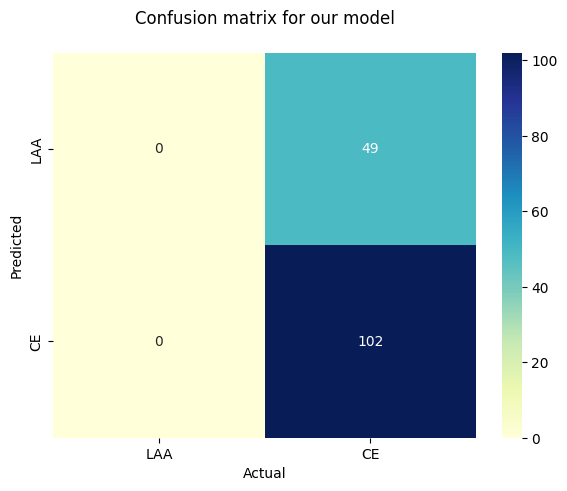

In [24]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## Submission for kaggle competition

In [25]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)


../input/mayo-clinic-strip-ai/test/006388_0.tif
../input/mayo-clinic-strip-ai/test/008e5c_0.tif
../input/mayo-clinic-strip-ai/test/00c058_0.tif
../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [26]:
cnn_pred=model.predict(test1)
cnn_pred

array([[9.1052127e-01],
       [1.1598005e-35],
       [9.0899700e-01],
       [9.0245450e-01]], dtype=float32)

In [27]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.910521,0.089479
1,008e5c,0.000000,1.000000
2,00c058,0.908997,0.091003
3,01adc5,0.902454,0.097546


In [28]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.910521,0.089479
008e5c,0.0,1.0
00c058,0.908997,0.091003
01adc5,0.902454,0.097546


# Approach 2

## DenseNET

In [29]:
del X_train
del Y_train

In [30]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


In [31]:
%%time
def preprocess_RGB(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size).convert('RGB')
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    #print(i)
    x1=preprocess_RGB(i)
    X_train.append(x1)
    
Y_train=train_df['target']

100%|██████████| 754/754 [33:34<00:00,  2.67s/it]

CPU times: user 14min 53s, sys: 3min 17s, total: 18min 10s
Wall time: 33min 34s


In [32]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [33]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [34]:
CE = 0
LAA = 0
for i in y_test:
    if i ==1:
        CE = CE+1
    else:
        LAA = LAA + 1
print(CE)
print(LAA)

102
49


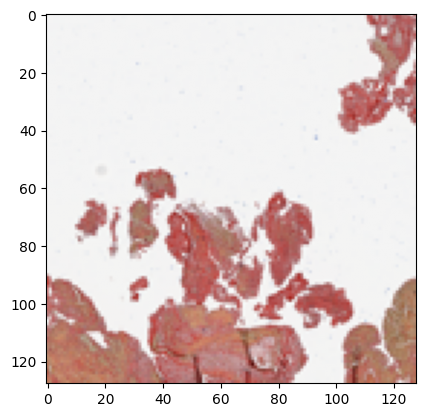

In [35]:
plt.imshow(x_test[0])

In [36]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [37]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

In [38]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from keras import layers
from keras import metrics

effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(128,128,3)
)

print(len(effnet.layers))
for layer in effnet.layers[0:200]:
    layer.trainable = True
for layer in effnet.layers[201::]:
    layer.trainable = False

Dense_model = Sequential()
Dense_model.add(effnet)
Dense_model.add(layers.GlobalAveragePooling2D())
Dense_model.add(layers.Dropout(0.5))
Dense_model.add(layers.Dense(512,activation='relu'))
Dense_model.add(layers.Dense(64,activation='relu'))
Dense_model.add(layers.Dense(1, activation='sigmoid'))

Dense_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

Dense_model.summary()

29097984/29084464 [==============================] - 2s 0us/step
427
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 7,595,201
Trainable params: 2,733,825

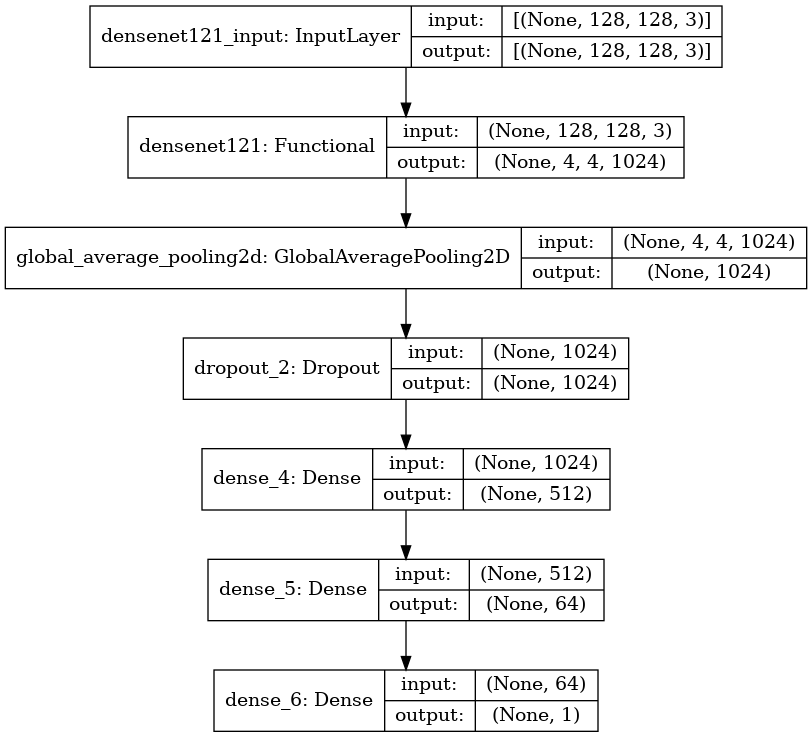

In [39]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(Dense_model, to_file=dot_img_file, show_shapes=True)

In [40]:
callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='Dense_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [41]:
Dense_model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback2   
)

Epoch 1/10
31/31 [==============================] - 14s 155ms/step - loss: 0.8300 - binary_accuracy: 0.5025 - f1_score: 0.5594 - val_loss: 0.9598 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0000e+00

Epoch 00001: val_binary_accuracy improved from -inf to 0.32450, saving model to Dense_best.h5
Epoch 2/10
31/31 [==============================] - 2s 75ms/step - loss: 0.7244 - binary_accuracy: 0.5207 - f1_score: 0.5867 - val_loss: 0.8193 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0000e+00

Epoch 00002: val_binary_accuracy did not improve from 0.32450
Epoch 3/10
31/31 [==============================] - 2s 65ms/step - loss: 0.7038 - binary_accuracy: 0.5622 - f1_score: 0.6256 - val_loss: 0.8422 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0000e+00

Epoch 00003: val_binary_accuracy did not improve from 0.32450
Epoch 4/10
31/31 [==============================] - 2s 71ms/step - loss: 0.6898 - binary_accuracy: 0.5705 - f1_score: 0.6104 - val_loss: 0.6791 - val_binary_accuracy: 0.6358 

In [42]:
best_Dense = load_model('/kaggle/working/Dense_best.h5', custom_objects={"f1_score": f1_score })
best_Dense.evaluate(x_test,y_test)

5/5 [==============================] - 3s 107ms/step - loss: 0.6791 - binary_accuracy: 0.6358 - f1_score: 0.7479


[0.6790857315063477, 0.6357616186141968, 0.7478863596916199]

Text(0.5, 25.722222222222214, 'Actual')

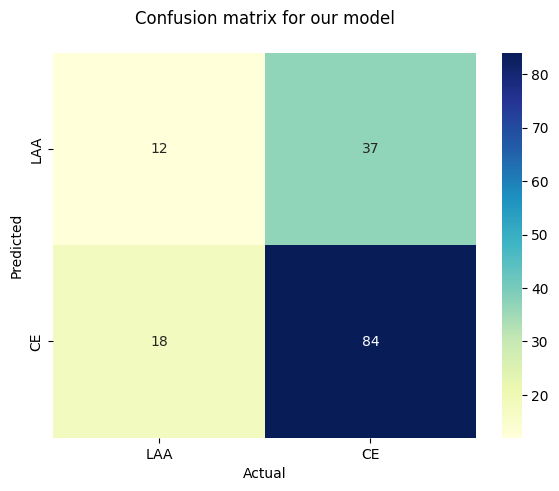

In [43]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_Dense.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")